<a href="https://colab.research.google.com/github/who-knows-its-nebulose/chair-style-classifier/blob/main/Train_chair_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install split_folders
import splitfolders

In [3]:
# Split 70:15:15 into training, validation and test

splitfolders.ratio('/content/drive/My Drive/colabdownloads/chairs/', output="/content/drive/My Drive/DS_projects/chair_classifier/", seed=1337, ratio=(.7, 0.15,0.15))

Copying files: 1414 files [08:53,  2.65 files/s]


In [5]:
#Import libraries
import os
import numpy as np
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

#variables
img_height = 224
img_width = 224
batch_size = 32

N_CLASSES = 5
TOTAL_EPOCHS = 50

#path
data_path = '/content/drive/My Drive/DS_projects/chair_classifier/'
train_data_path = data_path + 'train/'
val_data_path = data_path + 'val/'
test_data_path = data_path + 'test/'

#importing data
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_data_path,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle = False,
                                                        class_mode='categorical')


class_names = train_generator.classes
print(class_names)

Found 987 images belonging to 5 classes.
Found 211 images belonging to 5 classes.
Found 216 images belonging to 5 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [16]:
#Mapping class indices to category names

# classes = (train_generator.class_indices) 

# print(classes.items())

# predictions = [classes[k] for k in predicted_class_indices]


dict_items([('Farmhouse', 0), ('Industrial', 1), ('Midcentury', 2), ('Tropical', 3), ('Victorian', 4)])


[0. 0. 0. 0. 1.]


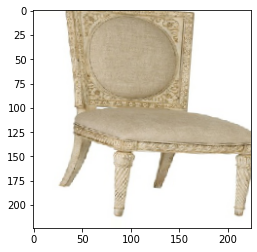

[0. 0. 0. 0. 1.]


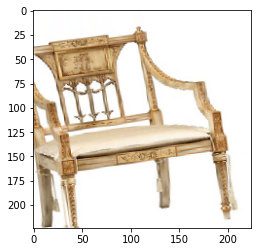

[0. 1. 0. 0. 0.]


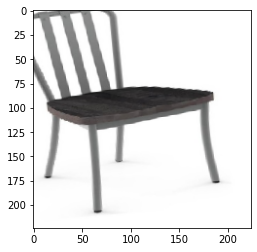

[1. 0. 0. 0. 0.]


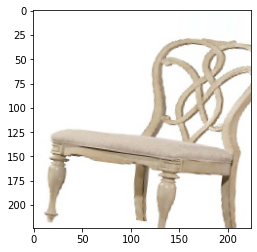

In [6]:
x,y = train_generator.next()
for i in range(0,4):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()
    

In [7]:

from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing



preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, 
                                                           img_width,
                                                              3),
                                               include_top=False,
                                               weights='imagenet',
                                               alpha = 1.4)


# preprocess_input = tf.keras.applications.vgg16.preprocess_input

# base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(img_height, img_width, 3)
#     )

base_model.trainable = False





#build model

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
preprocessed_input = preprocess_input(inputs)
base_model_out = base_model(preprocessed_input, training=False)
pooled = GlobalAveragePooling2D()(base_model_out)
drop1 = Dropout(0.2)(pooled)
dense1 = Dense(256, activation = 'relu')(drop1)
drop2 = Dropout(0.3)(dense1)
dense2 = Dense(128, activation = 'relu')(drop2)
drop3 = Dropout(0.2)(dense2)
outputs = Dense(5, activation='softmax')(drop3)
model = tf.keras.Model(inputs, outputs)


len(model.trainable_variables)


6

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/checkpoints_test/{epoch:02d}_{val_accuracy:.4f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy', 
    mode='max', 
    verbose=1,    
    save_best_only=True)   
 
reduce_lr =  ReduceLROnPlateau(patience=2, monitor='val_accuracy', factor = 0.25 , min_lr=1e-6, verbose=1)

early_stopping = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True, mode='max',verbose=1,min_delta=0.001)
          
Callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]    

In [9]:
TRAIN_DATASET_SIZE = len(train_generator)
VAL_DATASET_SIZE   = len(val_generator)

# Weighted losses for class equilibrium
# unique, counts = np.unique(ds_train.class_names, return_counts=True)
# class_weights = dict(zip(unique, np.true_divide(counts.sum(), N_CLASSES*counts)))
#/content/drive/My Drive/Colab Notebooks


# Prepare model to run
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
INITIAL_EPOCH = 0
# Start training the model
history = model.fit(train_generator,
                    epochs=TOTAL_EPOCHS,
                    verbose=1,
                    steps_per_epoch=TRAIN_DATASET_SIZE,
                    validation_data=val_generator,
                    validation_steps=VAL_DATASET_SIZE,
                    initial_epoch=INITIAL_EPOCH,
                    #workers = 4,
                    callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                    )

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.5950 - accuracy: 0.3050
Epoch 00001: val_accuracy improved from -inf to 0.40758, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_test/01_0.4076.h5
31/31 [==============================] - 16s 509ms/step - loss: 1.5950 - accuracy: 0.3050 - val_loss: 1.4373 - val_accuracy: 0.4076
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 1.5115 - accuracy: 0.3252
Epoch 00002: val_accuracy improved from 0.40758 to 0.43128, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_test/02_0.4313.h5
31/31 [==============================] - 15s 473ms/step - loss: 1.5115 - accuracy: 0.3252 - val_loss: 1.3853 - val_accuracy: 0.4313
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 1.4713 - accuracy: 0.3647
Epoch 00003: val_accuracy improved from 0.43128 to 0.46919, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_test/03_0.4692.h5
31/31 [============

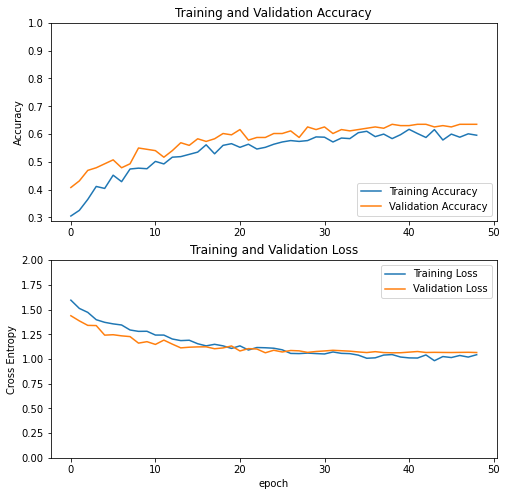

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [11]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

#num_of_test_samples = 261

Y_pred = model.predict(test_generator)#, num_of_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

#Mapping class indices to category names
labels = []
dict = (test_generator.class_indices)
print(dict)
for key, value in dict.items():
   labels.append(key)


print(classification_report(test_generator.classes, y_pred, target_names=labels))

Confusion Matrix
[[29  6  3  9  1]
 [ 6 35  7  1  0]
 [11  8 21  4  2]
 [ 4  5  5 32  2]
 [ 3  1  1  6 14]]
Classification Report
{'Farmhouse': 0, 'Industrial': 1, 'Midcentury': 2, 'Tropical': 3, 'Victorian': 4}
              precision    recall  f1-score   support

   Farmhouse       0.55      0.60      0.57        48
  Industrial       0.64      0.71      0.67        49
  Midcentury       0.57      0.46      0.51        46
    Tropical       0.62      0.67      0.64        48
   Victorian       0.74      0.56      0.64        25

    accuracy                           0.61       216
   macro avg       0.62      0.60      0.61       216
weighted avg       0.61      0.61      0.60       216



In [ ]:
classes = (train_generator.classes) 
print(classes)
print(classes.items())

predictions = [classes[k] for k in predicted_class_indices]
print(predictions)

In [42]:

  
print(labels)
# labels = dict((v,k) for k,v in labels.items())
# print(labels)
# predictions = [labels[k] for k in y_pred]
# print

{'Farmhouse': 0, 'Industrial': 1, 'Midcentury': 2, 'Tropical': 3, 'Victorian': 4}
['Farmhouse', 'Industrial', 'Midcentury', 'Tropical', 'Victorian']


In [38]:
print(predictions)

['Midcentury', 'Farmhouse', 'Tropical', 'Midcentury', 'Farmhouse', 'Industrial', 'Industrial', 'Tropical', 'Industrial', 'Tropical', 'Victorian', 'Farmhouse', 'Industrial', 'Tropical', 'Farmhouse', 'Tropical', 'Tropical', 'Farmhouse', 'Farmhouse', 'Tropical', 'Farmhouse', 'Industrial', 'Midcentury', 'Industrial', 'Industrial', 'Farmhouse', 'Industrial', 'Industrial', 'Midcentury', 'Farmhouse', 'Tropical', 'Victorian', 'Farmhouse', 'Tropical', 'Farmhouse', 'Tropical', 'Farmhouse', 'Tropical', 'Farmhouse', 'Victorian', 'Farmhouse', 'Farmhouse', 'Farmhouse', 'Midcentury', 'Farmhouse', 'Victorian', 'Victorian', 'Industrial', 'Farmhouse', 'Victorian', 'Tropical', 'Farmhouse', 'Farmhouse', 'Industrial', 'Industrial', 'Farmhouse', 'Farmhouse', 'Midcentury', 'Tropical', 'Farmhouse', 'Midcentury', 'Farmhouse', 'Farmhouse', 'Tropical', 'Industrial', 'Midcentury', 'Industrial', 'Midcentury', 'Farmhouse', 'Industrial', 'Farmhouse', 'Farmhouse', 'Farmhouse', 'Farmhouse', 'Midcentury', 'Farmhouse', 

In [ ]:

# #Import libraries
# import os
# import numpy as np
# from pathlib import Path
# import re
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import matplotlib.pyplot as plt


# #variables
# img_height = 224
# img_width = 224
# batch_size = 32

# N_CLASSES = 5
# TOTAL_EPOCHS = 50

# #path
# dataset_path = '/content/drive/My Drive/colabdownloads/chairs/train'

# #importing data


# ds_train = tf.keras.preprocessing.image_dataset_from_directory(
#     dataset_path,
#     labels = 'inferred',
#     label_mode = "categorical",
#     class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
#     color_mode = 'rgb',
#     batch_size = batch_size,
#     image_size = (img_height, img_width),
#     shuffle = True,
#     seed = 123,
#     validation_split = 0.2,
#     subset = "training",
# )

# ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
#     dataset_path,
#     labels = 'inferred',
#     label_mode = "categorical",
#     class_names= ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
#     color_mode = 'rgb',
#     batch_size = batch_size,
#     image_size = (img_height, img_width),
#     shuffle = False,
#     seed = 123,
#     validation_split = 0.2,
#     subset = "validation",
# )

# class_names = ds_train.class_names
# print(class_names)

# #look at the dataset

# plt.figure(figsize=(10, 10))
# for images, labels in ds_train.take(1):
#   for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
#     int_labels = np.argmax(labels, axis=-1)
#     plt.title(class_names[int_labels[i]])
#     plt.axis("off")



buffer autotune


In [ ]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# ds_train = ds_train.prefetch(buffer_size=AUTOTUNE) 
# ds_valid = ds_valid.prefetch(buffer_size=AUTOTUNE)

PREPROCESS and AUGMENT , make it part of the model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17833984/17831080 [==============================] - 1s 0us/step


6

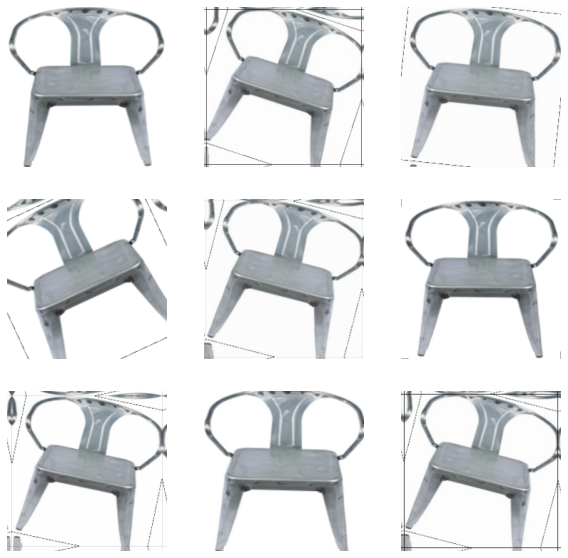

In [3]:
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

img_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
  ]
)

#look at augmented images
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, 
                                                           img_width,
                                                              3),
                                               include_top=False,
                                               weights='imagenet',
                                               alpha = 1.4)


base_model.trainable = False


#build model

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
aug_images = img_augmentation(inputs)
preprocessed_input = preprocess_input(aug_images)
base_model_out = base_model(preprocessed_input, training=False)
Pooled = GlobalAveragePooling2D()(base_model_out)
drop1 = Dropout(0.2)(Pooled)
dense1 = Dense(256, activation = 'relu')(drop1)
drop2 = Dropout(0.3)(dense1)
dense2 = Dense(128, activation = 'relu')(drop2)
drop3 = Dropout(0.2)(dense2)
outputs = Dense(5, activation='softmax')(drop3)
model = tf.keras.Model(inputs, outputs)


len(model.trainable_variables)



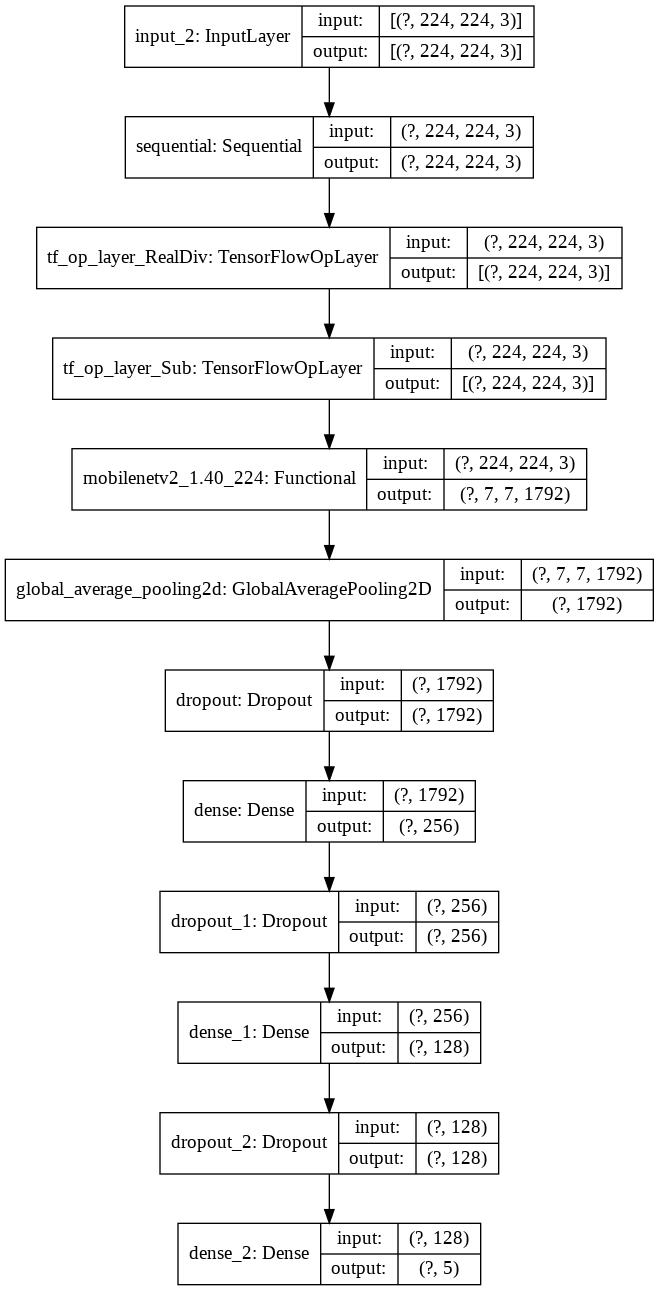

In [4]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names= True)

In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/checkpoints/{epoch:02d}_{val_accuracy:.4f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True)   
 
reduce_lr =  ReduceLROnPlateau(patience=4, monitor='val_accuracy', factor = 0.5 , min_lr=1e-6, verbose=1)

early_stopping = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True, mode='max',verbose=1,min_delta=0.004)
          
Callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]    



In [6]:
TRAIN_DATASET_SIZE = len(ds_train)
VAL_DATASET_SIZE   = len(ds_valid)

# Weighted losses for class equilibrium
# unique, counts = np.unique(ds_train.class_names, return_counts=True)
# class_weights = dict(zip(unique, np.true_divide(counts.sum(), N_CLASSES*counts)))
#/content/drive/My Drive/Colab Notebooks


# Prepare model to run
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
INITIAL_EPOCH = 0
# Starts training the model
history = model.fit(ds_train,
                    epochs=TOTAL_EPOCHS,
                    verbose=1,
                    steps_per_epoch=TRAIN_DATASET_SIZE,
                    validation_data=ds_valid,
                    validation_steps=VAL_DATASET_SIZE,
                    initial_epoch=INITIAL_EPOCH,
                    callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                    )

Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 1.1737 - accuracy: 0.5285 
Epoch 00001: val_accuracy improved from -inf to 0.68397, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints/01_0.6840.h5
56/56 [==============================] - 561s 10s/step - loss: 1.1737 - accuracy: 0.5285 - val_loss: 0.8121 - val_accuracy: 0.6840
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.7073
Epoch 00002: val_accuracy improved from 0.68397 to 0.83521, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints/02_0.8352.h5
56/56 [==============================] - 8s 137ms/step - loss: 0.7948 - accuracy: 0.7073 - val_loss: 0.4668 - val_accuracy: 0.8352
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.7422
Epoch 00003: val_accuracy did not improve from 0.83521
56/56 [==============================] - 7s 130ms/step - loss: 0.6905 - accuracy: 0.7422 - val_loss: 0.5357 - val_accurac

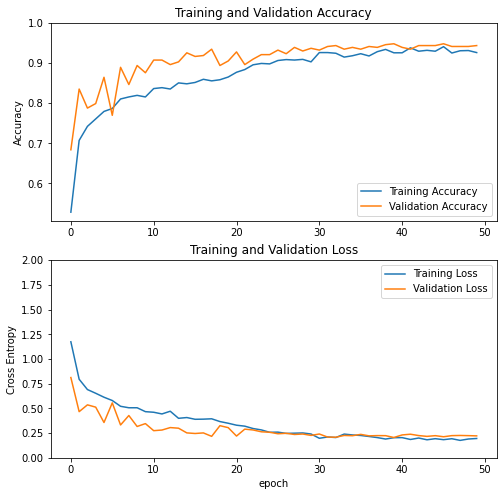

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [8]:
chair_checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoints/'
if Path(chair_checkpoint_path).exists():
  epoch_number_array = []
  val_accuracy_array = []
  file_name_array = []
  for file in os.listdir(chair_checkpoint_path):
      epoch, val_ac = re.search(r'(\d\d)_(\d\.\d{4})\.h5', file).group(1,2)
      epoch_number_array.append(int(epoch))
      val_accuracy_array.append(float(val_ac))
      file_name_array.append(file)

      if len(val_accuracy_array) == 0:
        INITIAL_EPOCH = 0
      else:
        highest_acc = val_accuracy_array.index(max(val_accuracy_array))
        INITIAL_EPOCH = epoch_number_array[highest_acc]
        model_checkpoint_callback.best = val_accuracy_array[highest_acc]
        model.load_weights(chair_checkpoint_path + file_name_array[highest_acc])
else:
  os.makedirs(chair_checkpoint_path)
  INITIAL_EPOCH = 0



In [9]:
print(val_accuracy_array[highest_acc])
print(INITIAL_EPOCH)

0.9481
40


In [10]:
model.save('/content/drive/My Drive/Colab Notebooks/model_chair_classifier_9481.h5')

In [14]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1. / 255,
#                                    rotation_range=40,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_data_path =  '/content/drive/My Drive/colabdownloads/chairs/test'
test_generator = test_datagen.flow_from_directory( test_data_path,
                                                        target_size=(img_height, img_width),
                                                        shuffle = False,
                                                        batch_size=18,
                                                        class_mode='categorical')
num_of_test_samples = 414

Y_pred = model.predict(test_generator, num_of_test_samples // 18)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"]
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


Found 414 images belonging to 5 classes.
Confusion Matrix
[[ 0 87  0  6  0]
 [ 0 78  0  9  0]
 [ 0 79  1  0  0]
 [ 0 71  0  9  0]
 [ 0 69  0  5  0]]
Classification Report
              precision    recall  f1-score   support

   Farmhouse       0.00      0.00      0.00        93
  Industrial       0.20      0.90      0.33        87
  Midcentury       1.00      0.01      0.02        80
    Tropical       0.31      0.11      0.17        80
   Victorian       0.00      0.00      0.00        74

    accuracy                           0.21       414
   macro avg       0.30      0.20      0.10       414
weighted avg       0.30      0.21      0.11       414



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FINE TUNE

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

base_learning_rate = 0.001

model.compile(optimizer = Adam(learning_rate=base_learning_rate/100),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
model.summary()

len(model.trainable_variables)

Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.40_224 (Functi (None, 7, 7, 1792)        4363712   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Drop

62

In [ ]:
history_fine = model.fit(ds_train,
                    epochs=TOTAL_EPOCHS,
                    verbose=1,
                    steps_per_epoch=TRAIN_DATASET_SIZE,
                    validation_data=ds_valid,
                    validation_steps=VAL_DATASET_SIZE,
                    initial_epoch=INITIAL_EPOCH,
                    callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                    )

Epoch 21/50
56/56 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8720
Epoch 00021: val_accuracy did not improve from 0.92780
56/56 [==============================] - 9s 155ms/step - loss: 0.3508 - accuracy: 0.8720 - val_loss: 0.2230 - val_accuracy: 0.9278
Epoch 22/50
56/56 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8821
Epoch 00022: val_accuracy did not improve from 0.92780
56/56 [==============================] - 8s 141ms/step - loss: 0.3341 - accuracy: 0.8821 - val_loss: 0.3878 - val_accuracy: 0.8623
Epoch 23/50
56/56 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8866
Epoch 00023: val_accuracy did not improve from 0.92780
56/56 [==============================] - 8s 139ms/step - loss: 0.3151 - accuracy: 0.8866 - val_loss: 0.2305 - val_accuracy: 0.9255
Epoch 24/50
56/56 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.8985
Epoch 00024: val_accuracy did not improve from 0.92780
56/56 [

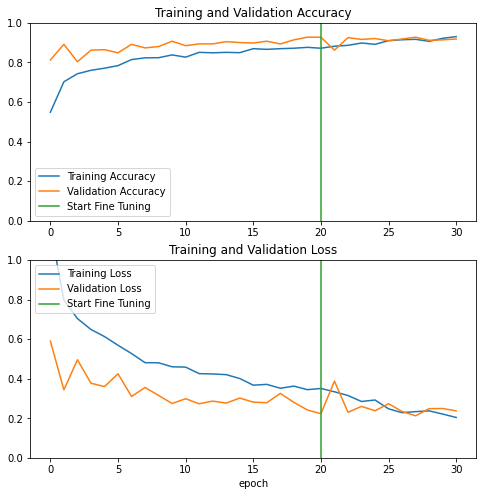

In [ ]:
acc[INITIAL_EPOCH:] = history_fine.history['accuracy']
val_acc[INITIAL_EPOCH:]= history_fine.history['val_accuracy']

loss[INITIAL_EPOCH:]= history_fine.history['loss']
val_loss[INITIAL_EPOCH:]= history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([INITIAL_EPOCH,INITIAL_EPOCH],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INITIAL_EPOCH, INITIAL_EPOCH],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/ML_models/chair_classifier/model_chair_classifier_finetuned_511.h5')


Enter your URLhttps://aca8cd9d105dbd447097-f6f51e4cef559c9308eef9d726fd38a7.ssl.cf1.rackcdn.com/471091-2.jpg
[[0.08362856 0.77366835 0.09105247 0.04180824 0.00984242]]
Industrial


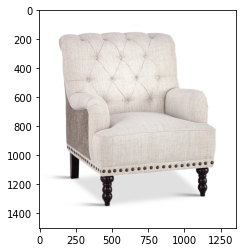

In [ ]:
#TEST
from keras.models import load_model
from keras.preprocessing import image
from skimage.io import imread
from skimage.transform import rescale, resize

model_trained = load_model('/content/drive/My Drive/ML_models/chair_classifier/model_chair_classifier_finetuned_511.h5')

url = input('Enter your URL')
img = imread(url)
plt.imshow(img)
class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"]

img_resized = resize(img,(224,224,3))
img_batch = np.expand_dims(img_resized,axis=0)
prediction_prob_array = model_trained.predict(img_batch)
print(prediction_prob_array)

max_prob_index = prediction_prob_array.argmax(axis=-1)
prediction = class_names[max_prob_index[0]]
print(prediction)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

num_of_test_samples = 414


test_datagen = ImageDataGenerator(rescale=1. / 255) 


validation_generator = test_datagen.flow_from_directory('/content/drive/My Drive/colabdownloads/test/',
                                                        target_size=(img_height, img_width),
                                                        shuffle = False,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')


Y_pred = model.predict(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 414 images belonging to 5 classes.
Confusion Matrix
[[ 0 93  0  0  0]
 [ 0 87  0  0  0]
 [ 0 80  0  0  0]
 [ 0 80  0  0  0]
 [ 0 74  0  0  0]]
Classification Report
              precision    recall  f1-score   support

   Farmhouse       0.00      0.00      0.00        93
  Industrial       0.21      1.00      0.35        87
  Midcentury       0.00      0.00      0.00        80
    Tropical       0.00      0.00      0.00        80
   Victorian       0.00      0.00      0.00        74

    accuracy                           0.21       414
   macro avg       0.04      0.20      0.07       414
weighted avg       0.04      0.21      0.07       414



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

type(ds_valid)

tensorflow.python.data.ops.dataset_ops.BatchDataset